In [158]:
# Importation de librairies 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
from pygam import LinearGAM


from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score,
                                     KFold)

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
import lazypredict
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score , mean_absolute_error , mean_absolute_error , mean_squared_error , r2_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from datetime import datetime
from keras.layers import Dropout

from pmdarima import auto_arima


pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [159]:
data.head()

sales  prix  wday  month  snap_WI
date                                         
2011-09-23  111.0  1.28     7      9        0
2011-09-24  168.0  1.28     1      9        0
2011-09-25  162.0  1.28     2      9        0
2011-09-26  127.0  1.28     3      9        0
2011-09-27   72.0  1.28     4      9        0

# Modelisation 

## Modeles de regression

In [160]:
#dataset ols avec variables one hot encodées, pour faire de la seleciton de variables 
data_ols = pd.read_csv("data_ols.csv")
# Indexer le dataset par le temps
data_ols['date'] = pd.to_datetime(data_ols['date'])
data_ols.set_index('date',inplace=True)

# Frequence journaliere 
data_ols.index.freq = 'D'

In [161]:
data_ols.head()

sales  prix  temp  feelslike  humidity  precip  windspeed  \
date                                                                    
2011-09-23  111.0  1.28   8.6        8.6      81.8   0.000       11.8   
2011-09-24  168.0  1.28   9.6        9.4      83.6   0.000       23.6   
2011-09-25  162.0  1.28  11.9       11.6      89.6   9.953       17.5   
2011-09-26  127.0  1.28  13.3       13.3      84.3  28.804       42.7   
2011-09-27   72.0  1.28  13.7       13.7      83.9   1.459       22.4   

            visibility  cloudcover  uvindex  extreme_temp  extreme_precip  \
date                                                                        
2011-09-23        15.8        71.0        6             0               0   
2011-09-24        11.2        68.1        5             0               0   
2011-09-25        13.3        89.1        4             0               0   
2011-09-26        10.6        91.3        3             0               1   
2011-09-27        13.7        84.7        5             0               0   

            preciptype_rain  preciptype_rain,snow  preciptype_snow  wday_1  \
date                                                                         
2011-09-23                0                     0                0       0   
2011-09-24                0                     0                0       1   
2011-09-25                1                     0                0       0   
2011-09-26                1                     0                0       0   
2011-09-27                1                     0                0       0   

            wday_2  wday_3  wday_4  wday_5  wday_6  wday_7  month_1  month_2  \
date                                                                           
2011-09-23       0       0       0       0       0       1        0        0   
2011-09-24       0       0       0       0       0       0        0        0   
2011-09-25       1       0       0       0       0       0        0        0   
2011-09-26       0       1       0       0       0       0        0        0   
2011-09-27       0       0       1       0       0       0        0        0   

            month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
date                                                                        
2011-09-23        0        0        0        0        0        0        1   
2011-09-24        0        0        0        0        0        0        1   
2011-09-25        0        0        0        0        0        0        1   
2011-09-26        0        0        0        0        0        0        1   
2011-09-27        0        0        0        0        0        0        1   

            month_10  month_11  month_12  snap_WI_0  snap_WI_1  
date                                                            
2011-09-23         0         0         0          1          0  
2011-09-24         0         0         0          1          0  
2011-09-25         0         0         0          1          0  
2011-09-26         0         0         0          1          0  
2011-09-27         0         0         0          1          0

Avant de passer a la modelisation , nous devons faire du OneHotEncoding pour les variables categorielles

D'abord nous allons mettre de coté un dataset validation, sur quoi nous allons evaluer notre modele finale, qu sont les derniere 28 jours

In [162]:
data_val = data_ols[data_ols.index >= '2016-04-25']
data_ols = data_ols[data_ols.index < '2016-04-25' ]

data_ols.shape , data_val.shape

((1676, 36), (28, 36))

Ensuite pour le train nous allons resrver environs 10% des donnes pour tester les models.

In [163]:
data_test = data_ols[data_ols.index >= '2015-12-31' ]
data_train = data_ols[data_ols.index < '2015-12-31' ]

X_train = data_train.drop(columns=['sales'],axis=1)
y_train = data_train['sales']

X_test = data_test.drop(columns=['sales'],axis=1)
y_test = data_test['sales']

X_train.shape , y_train.shape , X_test.shape , y_test.shape

((1560, 35), (1560,), (116, 35), (116,))

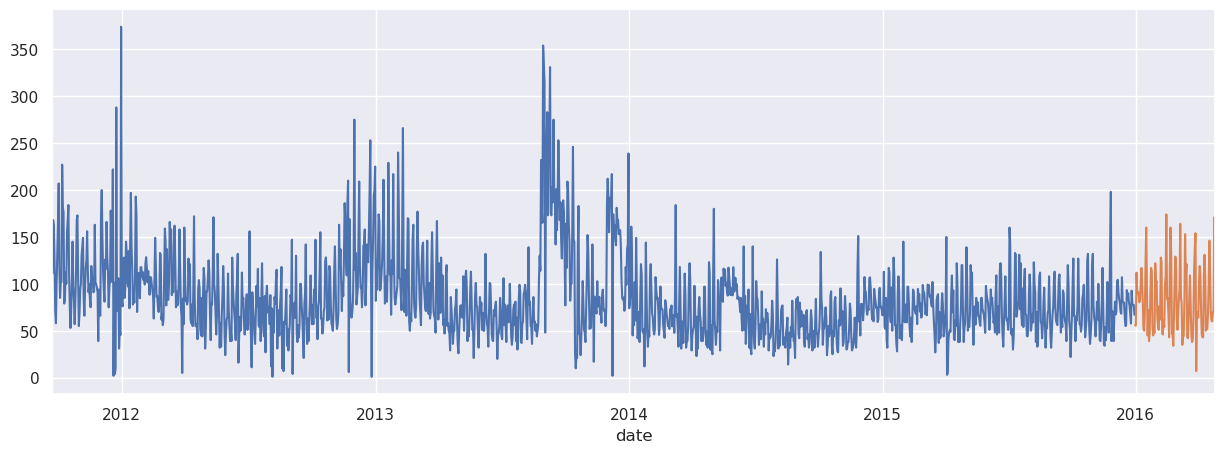

In [164]:
fig, ax = plt.subplots(figsize=(15,5))
y_train.plot(ax=ax)
y_test.plot(ax=ax)
ax.axvline()
plt.show()

## OLS

In [165]:
import statsmodels.api as sm
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     53.80
Date:                Fri, 13 Jan 2023   Prob (F-statistic):          5.61e-224
Time:                        22:37:02   Log-Likelihood:                -7554.3
No. Observations:                1560   AIC:                         1.517e+04
Df Residuals:                    1527   BIC:                         1.535e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
prix                  -223.9082      8.658    -25.862      0.000    -240.890    -206.926
temp                    -3.1285      1.104     -2.835      0.005      -5.293      -0.964
feelslike                3.1628      0.937      3.377      0.001       1.326       5.000
humidity                 0.1730      0.119      1.457      0.145      -0.060       0.406
precip                  -0.3867      0.234     -1.652      0.099      -0.846       0.072
windspeed                0.3509      0.143      2.462      0.014       0.071       0.630
visibility              -0.9209      0.472     -1.951      0.051      -1.847       0.005
cloudcover              -0.1516      0.038     -3.954      0.000      -0.227      -0.076
uvindex                 -0.2671      0.662     -0.404      0.687      -1.565       1.031
extreme_temp             8.7411      5.801      1.507      0.132      -2.638      20.121
extreme_precip           5.1218      7.402      0.692      0.489      -9.396      19.640
preciptype_rain         -0.7408      2.405     -0.308      0.758      -5.458       3.976
preciptype_rain,snow   -10.2707      4.029     -2.549      0.011     -18.173      -2.368
preciptype_snow          0.5346      4.374      0.122      0.903      -8.045       9.114
wday_1                 116.0854      4.165     27.874      0.000     107.916     124.254
wday_2                  92.0326      4.200     21.914      0.000      83.795     100.270
wday_3                  64.9198      4.247     15.286      0.000      56.589      73.250
wday_4                  61.2503      4.224     14.501      0.000      52.965      69.535
wday_5                  61.0231      4.167     14.644      0.000      52.849      69.197
wday_6                  64.3759      4.182     15.395      0.000      56.174      72.578
wday_7                  86.4498      4.213     20.522      0.000      78.187      94.713
month_1                 60.8736      4.101     14.843      0.000      52.829      68.918
month_2                 57.8229      4.111     14.064      0.000      49.758      65.887
month_3                 54.3643      3.476     15.640      0.000      47.546      61.182
month_4                 45.8529      3.779     12.132      0.000      38.439      53.266
month_5                 42.3007      3.997     10.584      0.000      34.461      50.140
month_6                 38.9738      4.687      8.316      0.000      29.781      48.167
month_7                 30.6060      4.916      6.225      0.000      20.962      40.250
month_8                 28.9306      4.720      6.129      0.000      19.672      38.189
month_9                 40.2674      3.890     10.353      0.000      32.638      47.897
month_10                36.2096      3.126     11.582      0.000      30.077      42.342
month_11                44.2035      3.379     13.084    

## Regresion lineaire, Polynomiale, Ridge, Lasso, ElasticNet

In [166]:
# Préparation des données
data = pd.read_csv("dataset_models.csv")
# Indexer le dataset par le temps
data['date'] = pd.to_datetime(data['date'])
data.set_index('date',inplace=True)

# Frequence journaliere 
data.index.freq = 'D'

In [167]:

data_val = data[data.index >= '2016-04-25']
data_train_test = data[data.index < '2016-04-25']
data_train = data[data.index < '2015-12-31']
data_test = data[(data.index >= '2015-12-31') & (data.index < '2016-04-25')]

X_train = data_train.drop(columns=['sales'],axis=1)
y_train = data_train['sales']

X_test = data_test.drop(columns=['sales'],axis=1)
y_test = data_test['sales']

X_train.shape , y_train.shape , X_test.shape , y_test.shape 

((1560, 4), (1560,), (116, 4), (116,))

Nous allons écrire une fonction qui calcule les principales métriques de performance pour évaluer les performances des modèles de régression.

In [168]:
def model_metrics(model,  X_train = X_train, y_train=y_train , X_test=X_test , y_test=y_test , decimals = 5):
    start  = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_test,y_pred)
    R2 = np.round(r2_score(y_test, y_pred),decimals)
    ecart = sum(np.abs(y_pred-y_test)<=10)/len(y_test)
    return {'MSE': MSE, "RMSE" : RMSE , 'MAE' : MAE ,
            'R2': R2, 'gap less than 0.1' : ecart,
            'time': (datetime.now() - start).seconds}

In [169]:
# Dictionnaire des modeles

dict_regressor = {
    "Bunchmark" : DummyRegressor(strategy="mean"),
    "Linreg": LinearRegression(),
    "Rdige" : Ridge(alpha=0.2),
    "LASSO" : Lasso(alpha=0.2),
    "ElasticNet" : ElasticNet(alpha=0.2) }

In [170]:
# Fonction qui retourne les resultas dans un dataframe

def run_regressor(dict_model):
  results = pd.DataFrame()
  model_names = [] 
  for key, value in dict_model.items():
    model_results = model_metrics(model=value)
    model_names.append(key)
    results = results.append(model_results, ignore_index=True)
  results['model'] = model_names
  results = results.reindex(columns=['model'] + list(results.columns[:-1]))
  return results

In [171]:
run_regressor(dict_regressor)

model          MSE       RMSE        MAE       R2  gap less than 0.1  \
0   Bunchmark  1236.102978  35.158256  29.694021 -0.00551           0.155172   
1      Linreg  1012.479501  31.819483  25.657662  0.17639           0.250000   
2       Rdige  1012.138299  31.814121  25.660733  0.17667           0.250000   
3       LASSO  1011.295879  31.800879  25.692577  0.17736           0.250000   
4  ElasticNet  1000.559651  31.631624  26.012946  0.18609           0.224138   

   time  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [172]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits)

In [173]:
# Initilaisaion des modeles et des hyperemtres poue chaque modele

model_ridge = Ridge()
model_Lasso = Lasso()
molde_EN = ElasticNet()

ridge_param = {'alpha': np.arange(0.01, 1.0, 0.1)}
lasso_param = {'alpha': np.arange(0.01, 1.0, 0.1)}
EN_param = { 'alpha':  np.arange(0.01, 1.0, 0.1) ,'l1_ratio' : np.arange(0.1, 1.0, 0.1)}

# liste des modele pour tuner
models = [model_ridge, model_Lasso, molde_EN]

# list des hyperparametres pour chaque modele
param_grids = [ridge_param, lasso_param, EN_param]
model_names = ['Ridge', 'Lasso', 'EN']

In [174]:
# Fonction qui renvoie le meilleure modèle
def find_best_models(models, param_grids):
    best_models = []
    for model, param_grid in zip(models, param_grids):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_models.append(grid_search.best_params_)

    for model, name in zip(best_models, model_names):
        print(f'{name}: {model}')

In [175]:
find_best_models(models= models,param_grids=param_grids)

Ridge: {'alpha': 0.01}
Lasso: {'alpha': 0.01}
EN: {'alpha': 0.01, 'l1_ratio': 0.9}


In [176]:
# modèles avec les bons paramètres
dict_regressor = {
    "Bunchmark" : DummyRegressor(strategy="mean"),
    "Linreg": LinearRegression(),
    "Rdige" : Ridge(alpha=0.01),
    "LASSO" : Lasso(alpha=0.01),
    "ElasticNet" : ElasticNet(alpha=0.01,l1_ratio=0.9)
}
run_regressor(dict_regressor)

model          MSE       RMSE        MAE       R2  gap less than 0.1  \
0   Bunchmark  1236.102978  35.158256  29.694021 -0.00551           0.155172   
1      Linreg  1012.479501  31.819483  25.657662  0.17639           0.250000   
2       Rdige  1012.462110  31.819210  25.657817  0.17641           0.250000   
3       LASSO  1012.409514  31.818383  25.659180  0.17645           0.250000   
4  ElasticNet  1010.094016  31.781976  25.681639  0.17833           0.250000   

   time  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [177]:
X = data_train_test.drop(columns=['sales'], axis=1)
# Fonction qui renvoi les predictin en train et en test
def model_predictions(model,  X_train = X_train, y_train=y_train , X_test=X_test , y_test=y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X)
    return y_pred

linreg_pred = model_predictions(model = LinearRegression())
ridge_pred = model_predictions(model = Ridge(alpha=0.01))
lasso_pred = model_predictions(model = Lasso(alpha=0.01))
EN_pred = model_predictions(model = ElasticNet(alpha=0.01,l1_ratio=0.9))
dummy_model = model_predictions(model=DummyRegressor(strategy="mean"))

In [178]:
# Create a trace for the true values and another trace for the predictions
trace0 = go.Scatter(x=data_train_test.index, y=data_train_test.sales, name='Valuers des ventes')
trace1 = go.Scatter(x=data_train_test.index, y=linreg_pred, name='Predictions')
trace2 = go.Scatter(x=data_train_test.index, y=ridge_pred, name='Predictions')
trace3 = go.Scatter(x=data_train_test.index, y=lasso_pred, name='Predictions')
trace4 = go.Scatter(x=data_train_test.index, y=EN_pred, name='Predictions')

# Create a list of traces and figures
traces = [trace1, trace2, trace3, trace4]
titles = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net']
figures = []

# Loop through the traces and create a figure for each trace
counter = 1
for trace, title in zip(traces, titles):
    figure_name = f"fig{counter}"
    figure = go.Figure(data=[trace0, trace])
    figure.update_layout(legend=dict(x=0, y=1), title=title, xaxis=dict(title='Time'), yaxis=dict(title='Value'))
    figures.append(figure)
    counter += 1

# Show the plots
for figure in figures:
    figure.show()


## Modèle Ensembliste

In [56]:
# Dictionnaire les modeles par defauts
dict_regressor = {
    "Bunchmark" : DummyRegressor(),
    "Knn" : KNeighborsRegressor(),
    "Arbre": DecisionTreeRegressor(),
    "RF" : RandomForestRegressor(),
    "ADA" : AdaBoostRegressor(),
     "XGB" : XGBRegressor(),
    "LGBM" : LGBMRegressor()    
}

In [57]:
run_regressor(dict_regressor)

model          MSE       RMSE        MAE       R2  gap less than 0.1  \
0  Bunchmark  1236.102978  35.158256  29.694021 -0.00551           0.155172   
1        Knn   705.299271  26.557471  20.502233  0.42627           0.267241   
2      Arbre   832.019465  28.844748  22.399525  0.32319           0.267241   
3         RF   801.585814  28.312291  21.843871  0.34795           0.258621   
4        ADA   762.125883  27.606628  22.207145  0.38005           0.241379   
5        XGB   800.494336  28.293009  21.919424  0.34883           0.284483   
6       LGBM   713.449355  26.710473  20.512422  0.41964           0.310345   

   time  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  
5   1.0  
6   0.0

In [58]:
# Initilaisaion des modeles et des hyperemtres poue chaque modele

model_Knn   = KNeighborsRegressor()
model_Arbre   = DecisionTreeRegressor()
model_RF = RandomForestRegressor(n_jobs=-1)
molde_ADA   = AdaBoostRegressor()
model_GB    = GradientBoostingRegressor()
model_XGB   = XGBRegressor(n_jobs=-1)
model_LGBM  = LGBMRegressor(n_jobs=-1)


Knn_param = {'n_neighbors': np.arange(1, 10, 1) }
arbre_param = {'criterion': ['squared_error','absolute_error'],  'max_features' : ['auto','sqrt','log2']}

RF_param = { 'n_estimators' : [100,500,1000] , 'max_features' : ['auto','sqrt','log2']}
ADA_param = {'n_estimators': [100,500,1000],'learning_rate' : [0.01,0.05,0.1,0.3,1],
             'loss': ['linear', 'square', 'exponential']}

GB_param = {'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
            'learning_rate' : [0.01,0.05,0.1,0.3,1],'n_estimators' : [100,500,1000],
            'criterion': ['friedman_mse','squared_error'],'max_features' : ['auto','sqrt','log2'] }

XGB_param =  {'objective':['reg:squarederror' , 'reg:squaredlogerror' ],
'learning_rate':[0.01,0.1,0.9], 
'n_estimators': [500,1000]}

LGBM_param = { 'boosting_type ': ['goss','rf'],'learning_rate' : [0.01,0.1,0.9],
'n_estimators': [500,1000]}


models_ens = [model_Knn, model_Arbre, model_RF, molde_ADA, model_GB,model_XGB,model_LGBM]
param_ens_grids = [Knn_param, arbre_param, RF_param , ADA_param, GB_param,XGB_param,LGBM_param]
model_ens_names = ['Knn', 'Arbre', 'RF','ADA', 'GB','XGB','LGBM']

In [60]:
# liste pour stocker les meilleurs modèles
best_models = []

for model, param_grid in zip(models_ens, param_ens_grids):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models.append(grid_search.best_params_)

# affichage des meilleurs modèles
for model, name in zip(best_models, model_ens_names):
    print(f'{name}: {model}')

[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: goss
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: goss
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: goss
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: goss
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: goss
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: goss
[LightGBM] [Warning] boosting_type is set=gbdt

In [59]:
dict_regressor = {
    "Bunchmark" : DummyRegressor(strategy='mean'),
    "Knn" : KNeighborsRegressor(n_neighbors= 9),
    "Arbre": DecisionTreeRegressor(criterion='squared_error',max_features='sqrt'),
    "RF" : RandomForestRegressor(max_features='sqrt'),
    "ADA" : AdaBoostRegressor(learning_rate = 0.01,loss= 'linear'),
    "GB" : GradientBoostingRegressor(criterion='friedman_mse',learning_rate=0.01,
                                    loss='huber',max_features='sqrt'),
    "XGB" : XGBRegressor(learning_rate = 0.01, n_estimators = 500, objective= 'reg:squarederror',n_jobs=-1),
    "LGBM" : LGBMRegressor(boosting_type= 'goss', learning_rate = 0.05, n_estimators = 1000, n_jobs=-1)
}

In [60]:
run_regressor(dict_regressor)

model          MSE       RMSE        MAE       R2  gap less than 0.1  \
0  Bunchmark  1236.102978  35.158256  29.694021 -0.00551           0.155172   
1        Knn   612.341692  24.745539  19.883110  0.50189           0.310345   
2      Arbre   832.019465  28.844748  22.399525  0.32319           0.267241   
3         RF   795.644965  28.207179  21.916431  0.35278           0.267241   
4        ADA   791.821440  28.139322  21.811414  0.35589           0.284483   
5         GB   965.095221  31.065982  24.874877  0.21494           0.232759   
6        XGB   718.674292  26.808101  20.708443  0.41539           0.301724   
7       LGBM   668.736909  25.859948  20.026516  0.45601           0.327586   

   time  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  
5   0.0  
6   0.0  
7   1.0

In [61]:
knn        = KNeighborsRegressor(n_neighbors=9).fit(X_train,y_train)
knn_pred   = knn.predict(data_train_test.drop(columns=['sales']))
Arbre_pred = model_predictions(model = DecisionTreeRegressor(criterion='squared_error',max_features='sqrt'))
RF_pred    = model_predictions(model = RandomForestRegressor(max_features='sqrt'))
ADA_pred   = model_predictions(model = AdaBoostRegressor(learning_rate = 0.01,loss= 'linear'))
GB_pred    = model_predictions(model = GradientBoostingRegressor())

XGB_pred   = model_predictions(model = XGBRegressor(learning_rate = 0.01,
                                                   n_estimators = 500, objective= 'reg:squarederror',n_jobs=-1) )
LGBM_pred  = model_predictions(model = LGBMRegressor(boosting_type= 'goss',
                                                     learning_rate = 0.05, n_estimators = 1000, n_jobs=-1))

In [62]:
#Trace pour les vrais valeurs et celles prédites
trace0 = go.Scatter(x=data_train_test.index, y=data_train_test.sales, name='vraie valeurs')
trace1 = go.Scatter(x=data_train_test.index, y=knn_pred, name='Predictions')
trace2 = go.Scatter(x=data_train_test.index, y=Arbre_pred, name='Predictions')
trace3 = go.Scatter(x=data_train_test.index, y=RF_pred, name='Predictions')
trace4 = go.Scatter(x=data_train_test.index, y=ADA_pred, name='Predictions')
trace5 = go.Scatter(x=data_train_test.index, y=GB_pred, name='Predictions')
trace6 = go.Scatter(x=data_train_test.index, y=XGB_pred, name='Predictions')
trace7 = go.Scatter(x=data_train_test.index, y=LGBM_pred, name='Predictions')

# Liste des traces et figures
traces = [trace1, trace2, trace3, trace4,trace5,trace6,trace7]
titles = ['Knn', 'Arbre', 'RandomForest', 'ADaboost','gradient','XGB','LGBM']
figures = []

# Affichage de chaque trace
counter = 1
for trace, title in zip(traces, titles):
    figure_name = f"fig{counter}"
    figure = go.Figure(data=[trace0, trace])
    figure.update_layout(legend=dict(x=0, y=1), title=title, xaxis=dict(title='Date'), yaxis=dict(title='Vente'))
    figures.append(figure)
    counter += 1

# Afifchage final 
for figure in figures:
    figure.show()

# GAM

In [63]:
# fONCTION POUR VOIR L4EFFET DE SPLIN SUR LES VARIABLES Explicative

def plot_model(model):
    fig, axes = plt.subplots(2, 1, figsize=(10,5));
    for i, (ax, title) in enumerate(zip(axes, X_train.columns)):
        XX = model.generate_X_grid(term=i)
        ax.plot(XX[:, i], model.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], model.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.set_title(title);

In [64]:
from pygam import GAM,s,l,f
#gam = LinearGAM(n_splines=24, lam=0.2, max_iter=1000, tol=1e-3).fit(X_train, y_train)
gam = GAM(link='identity', distribution='normal',lam=0.001).fit(X_train, y_train)


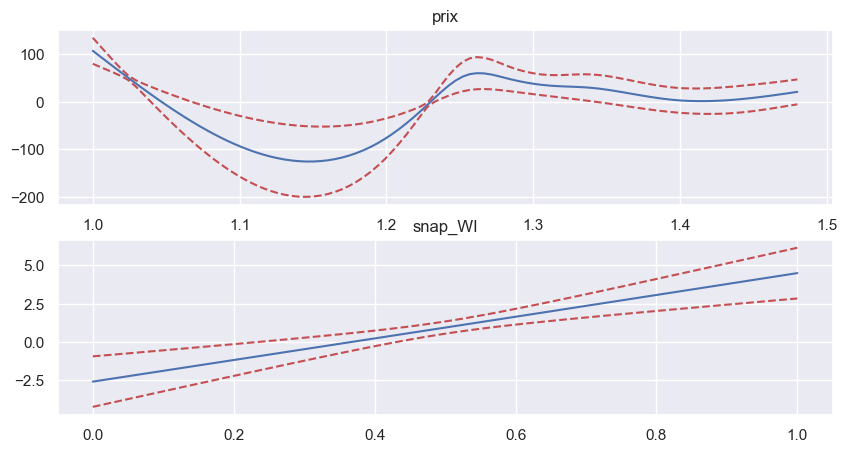

In [65]:
plot_model(gam)

In [66]:
model_metrics(model=gam)

{'MSE': 572.507791195654,
 'RMSE': 23.927135039441183,
 'MAE': 18.743377060219157,
 'R2': 0.53429,
 'gap less than 0.1': 0.31896551724137934,
 'time': 20}

In [67]:
y_pred_gam = model_predictions(LinearGAM())

In [68]:
trace0 = go.Scatter(x=data_train_test.index, y=data_train_test.sales, name='vraie valeurs')
trace1 = go.Scatter(x=data_train_test.index, y=y_pred_gam, name='Gam Predictions')

# Creation d'une liste avec traces et figures
traces = [trace1]
titles = ['GAM']
figures = []

# Itération sur nos listes
counter = 1
for trace, title in zip(traces, titles):
    figure_name = f"fig{counter}"
    figure = go.Figure(data=[trace0, trace])
    figure.update_layout(legend=dict(x=0, y=1), title=title, xaxis=dict(title='Date'), yaxis=dict(title='Vente'))
    figures.append(figure)
    counter += 1
    
#Affichage des graphiques
for figure in figures:
    figure.show()

#  ARIMAX

In [50]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

deco = sm.tsa.seasonal_decompose(data['sales'])

<AxesSubplot:xlabel='date'>

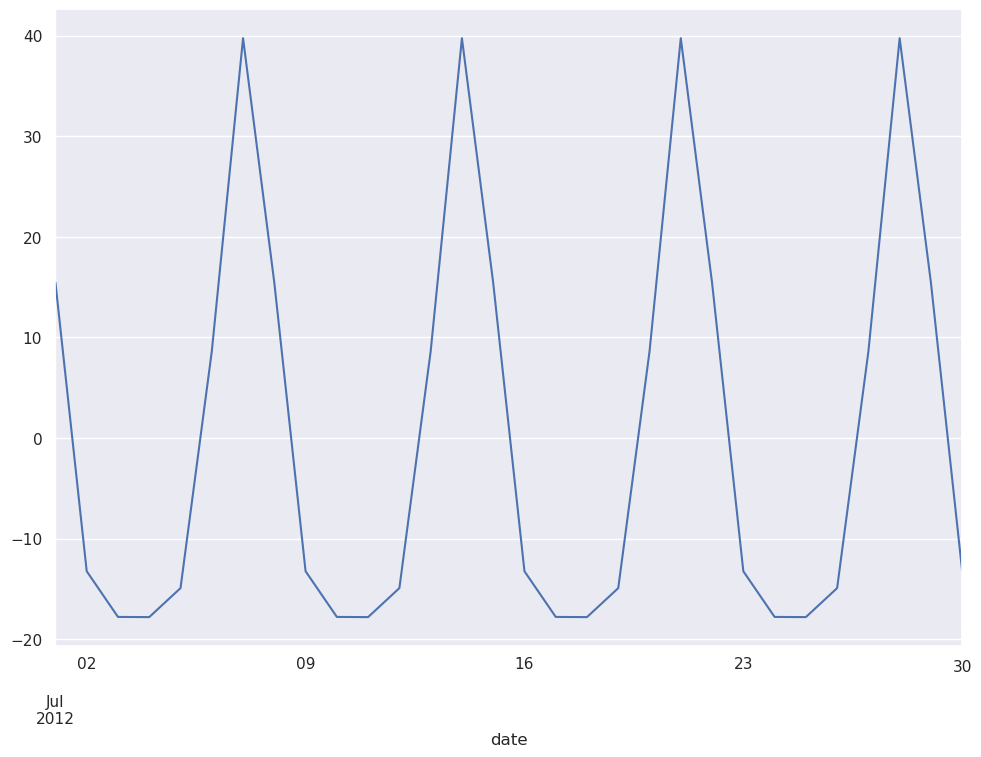

In [48]:
deco.seasonal['2012-07-01':'2012-07-30'].plot()

<AxesSubplot:xlabel='date'>

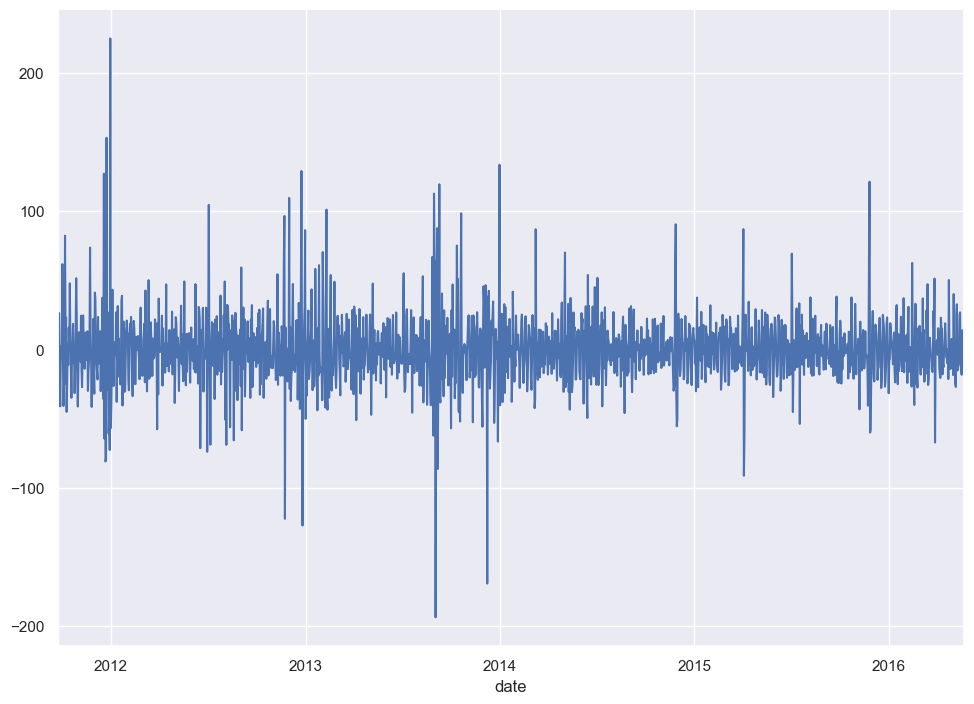

In [48]:
bruit = deco.resid
bruit.plot()

In [53]:
bruit = bruit[3:-3]
stat, pvalue = stats.normaltest(bruit)
# Interpretation

if pvalue < 0.05:
    print(f"La valeur de p est {pvalue}, qui est supérieure à 0,05, nous pouvons pas donc rejeter l'hypothèse nulle, et donc le bruit suis une loi normal.")
else:
    print(f"La valeur p est {pvalue}, qui est inferiere à 0,05, nous  pouvons donc pas rejeter l'hypothèse nulle donc le bruit suis une loi normal..")

La valeur de p est 1.534182268256854e-84, qui est supérieure à 0,05, nous pouvons pas donc rejeter l'hypothèse nulle, et donc le bruit suis une loi normal.


In [73]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['sales'])
pvalue = result[1]
critical_values = result[4]

if pvalue < 0.05:
    print("La valeur p est inférieure à 0,05, nous pouvons donc conclure que la série chronologique est stationnaire.")
else:
    print("La valeur de p est supérieure à 0,05, nous ne pouvons donc pas conclure que la série chronologique est stationnaire.")
    
if result[0] < critical_values['5%']:
    print("La statistique de test est inférieure à la valeur critique, nous pouvons donc conclure que la série temporelle est stationnaire.")
else:
    print("La statistique de test est supérieure à la valeur critique, nous ne pouvons donc pas conclure que la série temporelle est stationnaire.")


La valeur p est inférieure à 0,05, nous pouvons donc conclure que la série chronologique est stationnaire.
La statistique de test est inférieure à la valeur critique, nous pouvons donc conclure que la série temporelle est stationnaire.


In [74]:
#auto arima cherche la meilleur combinaison des coeff pour minimiser le critere aic 
model_arimax = auto_arima(y = y_train, xreg=X_train, max_p=10,max_q=10,seasonal=False,
                   trace=True, error_action="ignore", suppress_warnings=True)
model_arima = auto_arima(y = y_train,ax_p=10,max_q=10,
                   trace=True, error_action="ignore", suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15465.710, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16109.047, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16002.408, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15707.909, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16107.048, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15572.285, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15556.524, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15414.333, Time=1.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15489.482, Time=1.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=15366.599, Time=2.80 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15432.484, Time=1.38 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=15273.588, Time=2.78 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=15363.209, Time=0.85 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=15260.440, Time=3.55 sec
 ARIMA(6,1,1)(0,0,0

In [75]:
model_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1560
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -7587.786
Date:                Fri, 13 Jan 2023   AIC                          15191.572
Time:                        12:51:02   BIC                          15234.386
Sample:                    09-23-2011   HQIC                         15207.491
                         - 12-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2837      0.025     51.087      0.000       1.234       1.333
ar.L2         -1.1274      0.030    -37.149      0.000      -1.187      -1.068
ar.L3          0.1404      0.030      4.712      0.000       0.082       0.199
ar.L4         -0.0824      0.024     -3.440      0.001      -0.129      -0.035
ma.L1         -2.0227      0.019   -103.873      0.000      -2.061      -1.985
ma.L2          1.9314      0.028     70.175      0.000       1.877       1.985
ma.L3         -0.7670      0.017    -44.587      0.000      -0.801      -0.733
sigma2       982.1416     15.794     62.183      0.000     951.185    1013.098
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5162.03
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
model_arimax = sm.tsa.statespace.SARIMAX(endog=y_train,order=(4, 1, 3),exog=X_train).fit()

test_start = '2015-12-31'
test_end = '2016-04-24'
arimax_predictions = model_arimax.predict(test_start , test_end,exog=X_test)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83236D+00    |proj g|=  1.11402D-02


 This problem is unconstrained.



At iterate    5    f=  4.83168D+00    |proj g|=  4.36726D-03

At iterate   10    f=  4.83020D+00    |proj g|=  8.11589D-03

At iterate   15    f=  4.83005D+00    |proj g|=  8.44109D-04

At iterate   20    f=  4.82927D+00    |proj g|=  3.27727D-02

At iterate   25    f=  4.82368D+00    |proj g|=  4.43837D-03

At iterate   30    f=  4.82144D+00    |proj g|=  2.95402D-02

At iterate   35    f=  4.81235D+00    |proj g|=  5.91602D-03

At iterate   40    f=  4.81095D+00    |proj g|=  1.95621D-02

At iterate   45    f=  4.80936D+00    |proj g|=  6.38945D-03

At iterate   50    f=  4.80902D+00    |proj g|=  5.72539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [96]:
y_test_diff = y_test.diff()

trace0 = go.Scatter(x=data_test.index, y=y_test_diff, name='vraie valeurs')
trace2 = go.Scatter(x=data_test.index, y=arimax_predictions, name='arimax Predictions')

# Create a list of traces and figures
traces = [trace2]
titles = ['arimax']
figures = []

# Loop through the traces and create a figure for each trace
counter = 1
for trace, title in zip(traces, titles):
    figure_name = f"fig{counter}"
    figure = go.Figure(data=[trace0, trace])
    figure.update_layout(legend=dict(x=0, y=1), title=title, xaxis=dict(title='Date'), yaxis=dict(title='Vente'))
    figures.append(figure)
    counter += 1

# Show the plots
for figure in figures:
    figure.show()

In [97]:
#Calcul des metriques: 
y_test_diff[0] = y_test[0]#rajout valeur NaN
MSE = mean_squared_error(y_test_diff, arimax_predictions)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test_diff,arimax_predictions)

print('MSE:', MSE, "RMSE: ", RMSE , 'MAE:', MAE)

MSE: 1543.0960179323529 RMSE:  39.28226085566299 MAE: 32.193855884032416


# Agrégation 

In [84]:
reg_lin = LinearRegression().fit(X_train,y_train)
pred_reg = reg_lin.predict(X_test)
pred_gam  = gam.predict(X_test)
pred_knn = knn.predict(X_test)


# predictions des modéles 3* 28 jours de janvier - fevrier - mars concaténées
preds_1 = pred_reg.reshape(-1,1)
preds_2 = pred_gam.reshape(-1,1)
preds_3 = pred_knn.reshape(-1,1)
# Vrais valeurs sur ces 3*28 jours 
y_test = y_test
# fonction mse: 
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - np.squeeze(y_pred)))

# ensemble de combinaison convexe de predictions
weights = [[1/3, 1/3, 1/3], [1/2, 1/4, 1/4], [0.25, 0.25, 0.5], [0.25, 0.5, 0.25],
             [0.5, 0.5, 0], [0, 0.5, 0.5], [0.5, 0, 0.5], [1, 0, 0], [0, 1, 0], [0, 0, 1]]
pred_comb = []
tab_mse = []
for w in weights: 
    comb = w[0]*preds_1 + w[1]*preds_2 + w[2]*preds_3
    pred_comb.append(np.mean(comb,axis=-1))
    mse_ = mse(y_test, comb)
    tab_mse.append(mse_)

# trouver le meilleur poids
best_weight = weights[np.argmin(tab_mse)]
pred_comb = np.transpose(pred_comb)

In [85]:
best_weight

[1, 0, 0]

## Prediction finale sur le jeu de validation

In [86]:
X_train = data_train_test.drop(columns=['sales'],axis=1)
y_train = data_train_test.sales

X_val = data_val.drop(columns=['sales'],axis=1)
y_val = data_val.sales

X_train.shape , y_train.shape , X_val.shape , y_val.shape

((1676, 21), (1676,), (28, 21), (28,))

In [87]:
reg = LinearRegression().fit(X_train,y_train)
finale_prediction_reg = reg.predict(X_val)
mse_ = mean_squared_error(y_val,finale_prediction_reg)
mae_ = mean_absolute_error(y_val,finale_prediction_reg)
rmse = np.sqrt(mse_)
r2 = r2_score(y_val,finale_prediction_reg)
print(mse_,mae_,rmse,r2)

460.8411675201325 16.293546482096907 21.467211451889426 0.5683990633319828


In [88]:
gam = GAM().fit(X_train,y_train)
finale_prediction = gam.predict(X_val)
mse_ = mean_squared_error(y_val,finale_prediction)
mae_ = mean_absolute_error(y_val,finale_prediction)
rmse = np.sqrt(mse_)
r2 = r2_score(y_val,finale_prediction)
print(mse_,mae_,rmse,r2)

471.139606896718 16.13542482459254 21.705750549030043 0.5587540567778343


In [89]:
knn = KNeighborsRegressor(n_neighbors=9).fit(X_train,y_train)
finale_prediction = knn.predict(X_val)
mse_ = mean_squared_error(y_val,finale_prediction)
mae_ = mean_absolute_error(y_val,finale_prediction)
rmse = np.sqrt(mse_)
r2 = r2_score(y_val,finale_prediction)
print(mse_,mae_,rmse,r2)

475.169356999022 18.62858538381443 21.798379687468103 0.5549799930845849


In [90]:
trace0 = go.Scatter(x=data_val.index, y=data_val.sales, name='vraie valeurs')
trace1 = go.Scatter(x=data_val.index, y=finale_prediction_reg, name='RL Predictions')

# Create a list of traces and figures
traces = [trace1]
titles = ['Regression lineare']
figures = []

# Loop through the traces and create a figure for each trace
counter = 1
for trace, title in zip(traces, titles):
    figure_name = f"fig{counter}"
    figure = go.Figure(data=[trace0, trace])
    figure.update_layout(legend=dict(x=0, y=1), title=title, xaxis=dict(title='Date'), yaxis=dict(title='Vente'))
    figures.append(figure)
    counter += 1

# Show the plots
for figure in figures:
    figure.show()